In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import matplotlib.pyplot as plt

2024-08-12 01:50:40.187168: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 01:50:40.246452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 01:50:40.305928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 01:50:40.353194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 01:50:40.366567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 01:50:40.458139: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Get project files
#wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

#unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [59]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, 
                                                           target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           batch_size=128,
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                              shuffle=True,
                                                              color_mode='rgb',
                                                              batch_size=32,
                                                              class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                         target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                         shuffle=False,
                                                         color_mode='rgb',
                                                         batch_size=50, 
                                                         class_mode='binary',
                                                         classes=['.'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


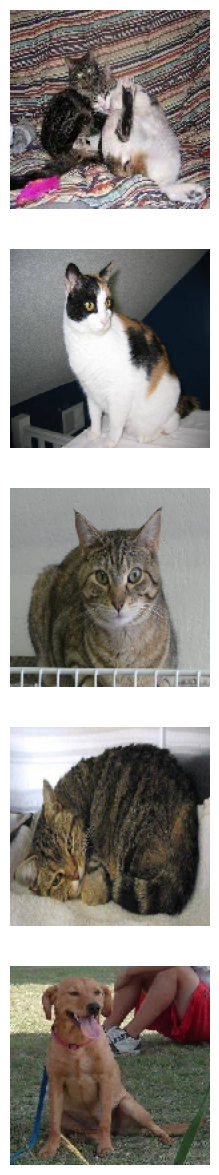

In [60]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [61]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.3,horizontal_flip=True, 
                                           vertical_flip=True)


Found 2000 images belonging to 2 classes.


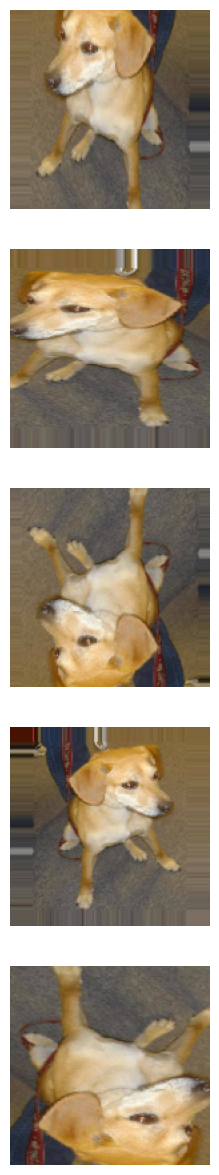

In [62]:
# 6
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     shuffle=True,
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [63]:
# 7
model = Sequential([Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    Conv2D(16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.8),
    Dense(1, activation='sigmoid'),
])

model.summary()

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,513 (3.44 MB)

 Trainable params: 900,513 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# 8
spe = train_data_gen.samples // train_data_gen.batch_size
vs = val_data_gen.samples // val_data_gen.batch_size

history = model.fit(train_data_gen,
          steps_per_epoch = spe,
          epochs = epochs,
          validation_data = val_data_gen,
          validation_steps = vs)

Epoch 1/15


/home/mostafa/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 333ms/step - accuracy: 0.4861 - loss: 0.7016 - val_accuracy: 0.5020 - val_loss: 0.6849
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5781 - loss: 0.6724 - val_accuracy: 0.2500 - val_loss: 0.6895
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 332ms/step - accuracy: 0.5469 - loss: 0.6876 - val_accuracy: 0.6028 - val_loss: 0.6615
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6094 - loss: 0.6421 - val_accuracy: 0.1250 - val_loss: 0.8759
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.5570 - loss: 0.6847 - val_accuracy: 0.5514 - val_loss: 0.6699
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.5312 - loss: 0.6721 - val_accuracy: 0.7500 - val_loss: 0.6195
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 331ms/step - accuracy: 0.5945 - loss: 0.6664 - val_accuracy: 0.6089 - val_loss: 0.6639
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.5625 - loss: 0.6394 - val_accuracy: 0.7500 - 

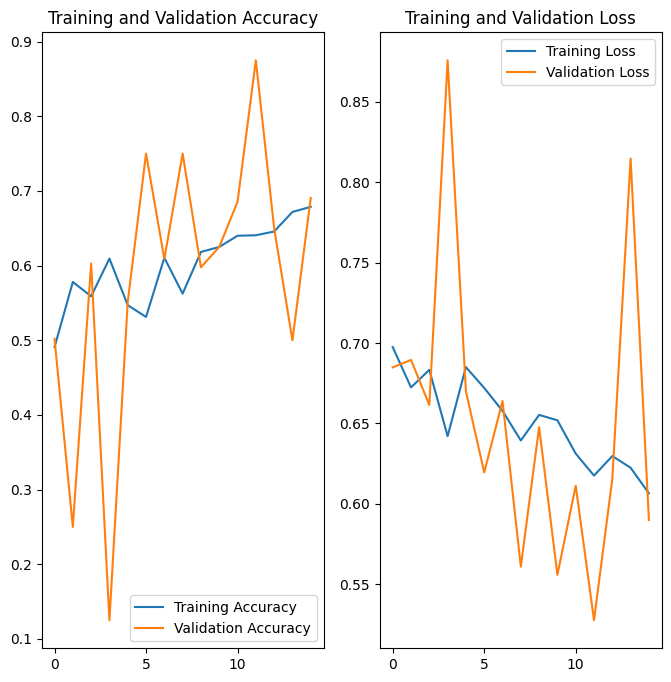

In [65]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


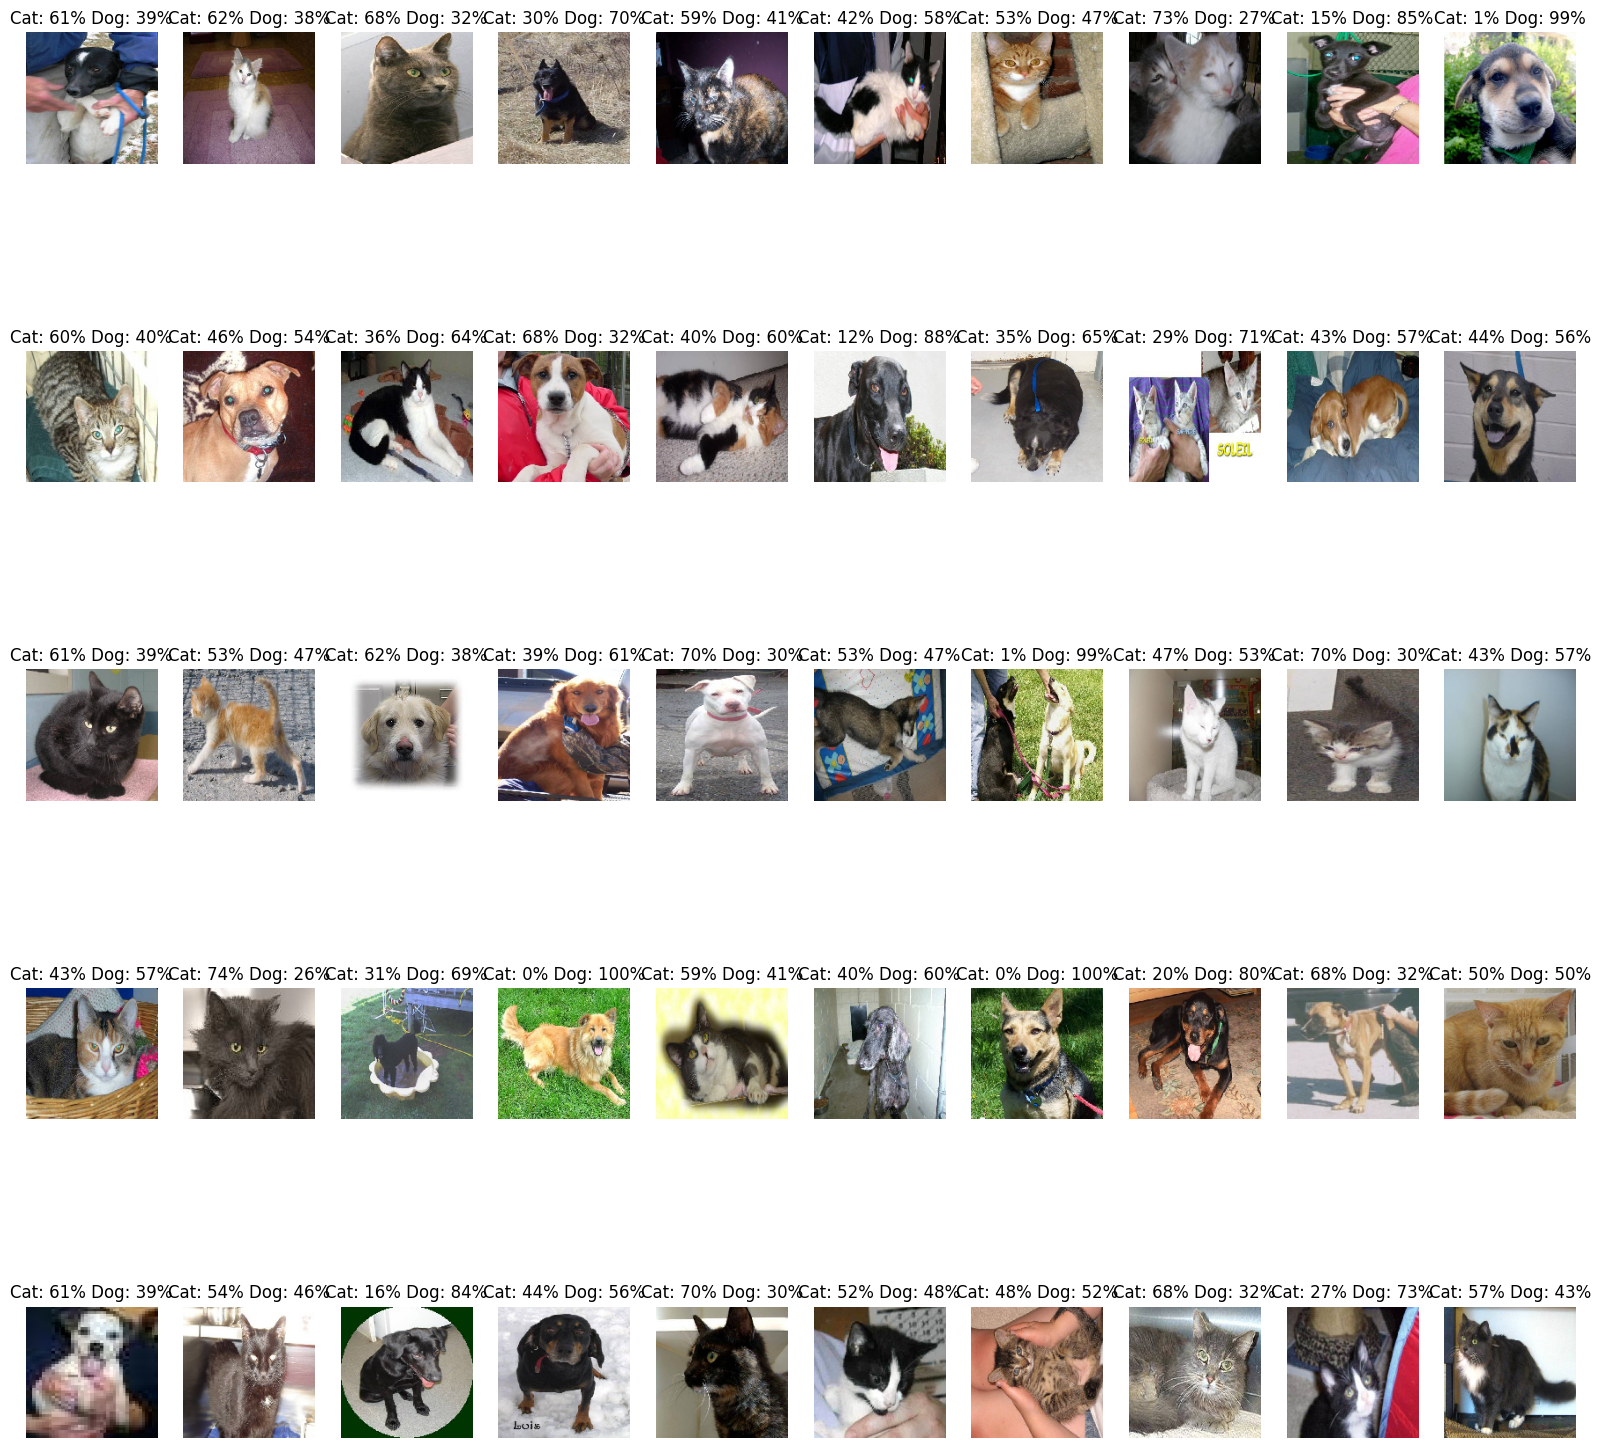

In [66]:
# 10
probabilities = model.predict(test_data_gen)

test_images = next(test_data_gen)[0]
plt.figure(figsize=(20, 20))
for i in range(len(test_images)):
    dog_prob = round(probabilities[i].item() * 100)
    cat_prob = 100 - dog_prob
    plt.subplot(5, 10, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Cat: {cat_prob}% Dog: {dog_prob}%")
    plt.axis('off')
plt.show()

In [68]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability.item()) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
